# Exploring GCVSPL

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We roughly follow the example data from scipy documentation:
    
    https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.interpolate.UnivariateSpline.html
    
However, instead of using a uniformly distributed noise, we use a gaussian noise with 
well defined variance of 0.01. (std = 0.1). It is easier to illustrate the statistical
meaning of the GCVSPL outputs under this assumption.

In [45]:
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline
from gcvspline import GCVSmoothedNSpline, MSESmoothedNSpline, DOFSmoothedNSpline, SmoothedNSpline
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline

In [3]:
x = np.linspace(-3, 3, 50)
y0 = np.exp(-x**2)
np.random.seed(1234)

n = 0.1 * np.random.normal(size=50)
w = 1.0 / (np.ones_like(n) * std(n))
y = y0 + n

## The most automated smoothing

- comparing between `scipy.interpolate.UnivariateSpline` and `GCVSmoothedNSpline`

In [4]:
xs = np.linspace(-3, 3, 1000)

In [47]:
DX_auto = UnivariateSpline(x, y, w=w)
GCV_auto = GCVSmoothedNSpline(x, y, w=w)

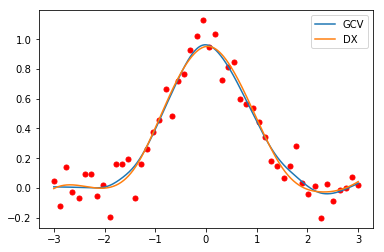

In [46]:
ax = subplot(111)
ax.plot(x, y, 'ro', ms=5)
ax.plot(xs, GCV_auto(xs), label='GCV')
ax.plot(xs, DX_auto(xs), label='DX')
legend()

A few comments:

 - the GCV splines are natural splines, thus smoother on the edges.

## Smoothing modes of GCVSPL

- GCV: Selecting smoothing parameter such that the Generalized cross validation magic.
- Manual : manually setting the smoothing parameter `p`.
- MSE: Smoothing by fitting to a desired mean square error.
- DOF: Smoothing by killing a given number of degrees of freedom in the fitted data.

There is an implicit constraint between MSE, DOF, p, and the weights (w, w1); they are not dependent.

### Consistency

Using the fitted values of the splines gives consistent results, up to numerical error

In [32]:
GCV_mse = MSESmoothedNSpline(x, y, w=w, variance_metric=GCV_auto.variance_metric)
GCV_dof = DOFSmoothedNSpline(x, y, w=w, dof=GCV_auto.dof)
GCV_manual = SmoothedNSpline(x, y, w=w, p=GCV_auto.p)

In [63]:
print(GCV_mse.variance_metric, GCV_mse.mse, GCV_mse.msr, GCV_mse.dof, GCV_mse.p)
print(GCV_dof.variance_metric, GCV_dof.mse, GCV_dof.msr, GCV_dof.dof, GCV_dof.p)
print(GCV_auto.variance_metric, GCV_auto.mse, GCV_auto.msr, GCV_auto.dof, GCV_auto.p)
print(GCV_manual.variance_metric, GCV_manual.mse, GCV_auto.msr, GCV_manual.dof, GCV_manual.p)

1.10921147023 0.198876509296 0.91033496093 41.0352302228 4.75976896354
1.1092114453 0.198876525282 0.910334920021 41.0352293008 4.75976675388
1.10921147023 0.198876509296 0.91033496093 41.0352302228 4.75976896354
1.10921147023 0.198876509296 0.91033496093 41.0352302228 4.75976896354


Note: MSE + MSR == Variance_metric; MSE are the mean square errors affecting the data.

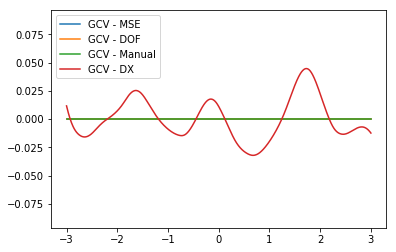

In [49]:
plot(xs, GCV_auto(xs) - GCV_mse(xs), label='GCV - MSE')
plot(xs, GCV_auto(xs) - GCV_dof(xs), label='GCV - DOF')
plot(xs, GCV_auto(xs) - GCV_manual(xs), label='GCV - Manual')
plot(xs, GCV_auto(xs) - DX_auto(xs), label='GCV - DX')
ylim(-std(n), std(n))
legend()

### GCV is robust against the scaling of w



variance of the first data item is 0.0102897041416
variance of the first data item is 0.0102897037596
variance of the first data item is 0.0102897041416


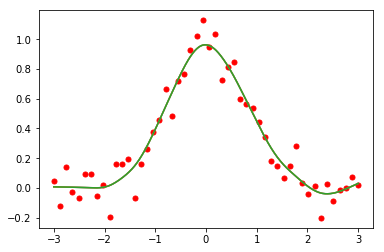

In [118]:
def check_w2(ax):
    r = []
    for wf in [0.1, 1.0, 10.0]:
        GCV2 = GCVSmoothedNSpline(x, y, w=w * wf)
        ax.plot(xs, GCV2(xs), label='w= w * %g' % (wf))
        r.append([wf, GCV2.mse, GCV2.dof])
        print('variance of the first data item is', GCV2.variance[0][0])
    return np.array(r)
ax = subplot(111)
ax.plot(x, y, 'ro', ms=5)
r = check_w2(ax)

## Manually setting parameter `p`

- Larger p gives more smoothing

In [74]:
def check_p(ax):
    r = []
    for pf in [0.1, 1.0, 10.0]:
        p = GCV_auto.p * pf
        GCV_manual = SmoothedNSpline(x, y, w=w, p=p)
        ax.plot(xs, GCV_manual(xs), label='p=%g' % p)
        r.append([p, GCV_manual.mse, GCV_manual.dof])
    return r

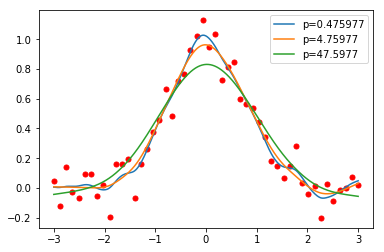

In [75]:
ax = subplot(111)
ax.plot(x, y, 'ro', ms=5)
check_p(ax)
legend()

### `p` and `w` are degenerate

- Be aware that `p` and `w` are degenerate;
- Fixing p and changing w gives different smoothing;
- For the same fitting result, p scales as `w ** 2`.

In [95]:
def check_p2(ax):
    r = []
    for wf in [0.1, 1.0, 10.0]:
        GCV_manual = SmoothedNSpline(x, y, w=w * wf, p=GCV_auto.p * wf ** 2)
        ax.plot(xs, GCV_manual(xs), label='w= w * %g, p=p * %g' % (wf, wf**2))
        r.append([wf, GCV_manual.mse, GCV_manual.dof])
    return r

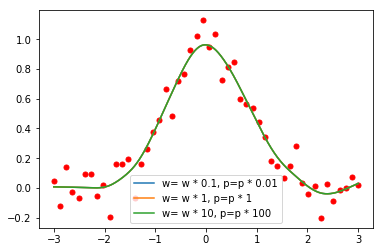

In [96]:
ax = subplot(111)
ax.plot(x, y, 'ro', ms=5)
check_p2(ax)
legend()

## MSE: Manually setting parameter `variance_metric`

- Larger variance_metric suggests larger variance in the data, thus a smooth model

In [100]:
def check_mse(ax):
    for variance_metric in [0.1, 1.0, 10.0]:
        GCV_mse = MSESmoothedNSpline(x, y, w=w, variance_metric=variance_metric)
        ax.plot(xs, GCV_mse(xs), label='variance metric=%g' % variance_metric)
        #print(GCV_mse.mse, GCV_mse.dof, variance_metric)

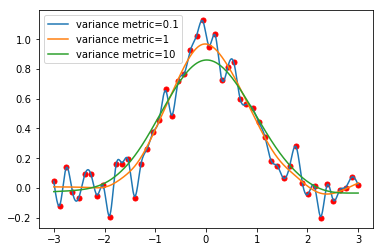

In [101]:
ax = subplot(111)
ax.plot(x, y, 'ro', ms=5)
check_mse(ax)
legend()

### `variance_metric` and `w` are degenerate

- be aware that `variance_metric` and `w` are degenerate;
- For the same fitting result, variance_metric scales as `w ** 2`.

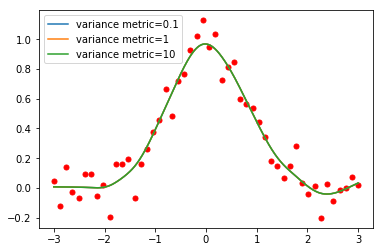

In [105]:
def check_mse2(ax):
    for variance_metric in [0.1, 1.0, 10.0]:
        GCV_mse = MSESmoothedNSpline(x, y, w=w * variance_metric ** 0.5, 
                                     variance_metric=variance_metric)
        ax.plot(xs, GCV_mse(xs), label='variance metric=%g' % variance_metric)
        #print(GCV_mse.mse, GCV_mse.dof, variance_metric)
ax = subplot(111)
ax.plot(x, y, 'ro', ms=5)
check_mse2(ax)
legend()        

## DOF: Manually setting parameter `dof`

- More DOF in the residual means the data is noiser, thus a smoother model.

In [107]:
def check_dof(ax):
    for doff in [0.5, 1.0, 2.0]:
        # not a particular model, but looked like a good heuristic
        dof = len(y) - len(y) ** 0.5 * doff
        GCV_dof = DOFSmoothedNSpline(x, y, dof=dof, w=w)
        ax.plot(xs, GCV_dof(xs), label='dof=%g' % dof)
        print(GCV_dof.dof, dof)

46.4644657936 46.46446609406726
42.9289327811 42.928932188134524
35.8578635699 35.85786437626905


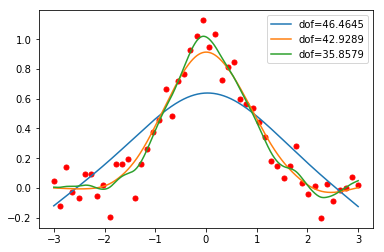

In [108]:
ax = subplot(111)
ax.plot(x, y, 'ro', ms=5)
check_dof(ax)
legend()

### the dof is degenerate with w.

- the relation is not easily described.
- XXX: is there a relation?

46.4644657936 46.46446609406726
42.9289327811 42.928932188134524
35.8578635699 35.85786437626905


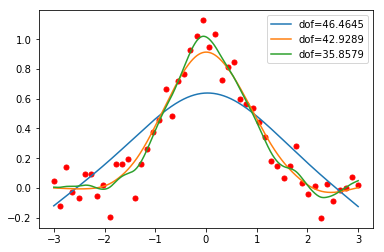

In [109]:
def check_dof2(ax):
    for wf in [0.1, 1.0, 10.0]:
        # not a particular model, but looked like a good heuristic
        GCV_dof = DOFSmoothedNSpline(x, y, dof=GCV_auto.dof, w=w * wf)
        ax.plot(xs, GCV_dof(xs), label='wf=%g' % wf)
        #print(GCV_dof.dof, dof)
ax = subplot(111)
ax.plot(x, y, 'ro', ms=5)
check_dof(ax)
legend()